In [2]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable

# Not needed in notebook

In [3]:
# Training settings
parser = argparse.ArgumentParser(description='PyTorch MNIST Example')
parser.add_argument('--batch-size', type=int, default=64, metavar='N',
                    help='input batch size for training (default: 64)')
parser.add_argument('--test-batch-size', type=int, default=1000, metavar='N',
                    help='input batch size for testing (default: 1000)')
parser.add_argument('--epochs', type=int, default=10, metavar='N',
                    help='number of epochs to train (default: 10)')
parser.add_argument('--lr', type=float, default=0.01, metavar='LR',
                    help='learning rate (default: 0.01)')
parser.add_argument('--momentum', type=float, default=0.5, metavar='M',
                    help='SGD momentum (default: 0.5)')
parser.add_argument('--no-cuda', action='store_true', default=False,
                    help='disables CUDA training')
parser.add_argument('--seed', type=int, default=1, metavar='S',
                    help='random seed (default: 1)')
parser.add_argument('--log-interval', type=int, default=10, metavar='N',
                    help='how many batches to wait before logging training status')
args = parser.parse_args()
args.cuda = not args.no_cuda and torch.cuda.is_available()

torch.manual_seed(args.seed)
if args.cuda:
    torch.cuda.manual_seed(args.seed)


kwargs = {'num_workers': 1, 'pin_memory': True} if args.cuda else {}

usage: __main__.py [-h] [--batch-size N] [--test-batch-size N] [--epochs N]
                   [--lr LR] [--momentum M] [--no-cuda] [--seed S]
                   [--log-interval N]
__main__.py: error: unrecognized arguments: -f /run/user/1000/jupyter/kernel-a84376f6-9dc9-4899-a236-d7bba7c21fa5.json


SystemExit: 2

/home/kamen/Frameworks/anaconda3/envs/pytorch/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2918: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


# Running from the root makes things easy

In [5]:
%cd ../..

/home/kamen/Workspace/Coursework/year4/mlp/mlp-03


# Setup data provider

In [76]:
train_batch_size = 64
test_batch_size = 8

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('datasets/mnist', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=train_batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('datasets/mnist', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=test_batch_size, shuffle=True)

# Define models

In [27]:
lr = 0.01
momentum = 0.5
cuda = True

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=3, padding=1),  # b, 16, 10, 10
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=2),  # b, 16, 5, 5
            nn.Conv2d(16, 8, 3, stride=2, padding=1),  # b, 8, 3, 3
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=1)  # b, 8, 2, 2
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(8, 16, 3, stride=2),  # b, 16, 5, 5
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 5, stride=3, padding=1),  # b, 8, 15, 15
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 2, stride=2, padding=1),  # b, 1, 28, 28
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
model = autoencoder()
if cuda:
    model.cuda()

optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

# Train models

In [29]:
log_interval = 10

def train(epoch):
    model.train()
    for batch_idx, (data, _) in enumerate(train_loader):
        # Autoencoder
        target = data
        if cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)
        loss = F.mse_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data[0]))

def test():
    model.eval()
    test_loss = 0
    correct = 0
    for data, _ in test_loader:
        # Autoencoder
        target = data
        if cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data, volatile=True), Variable(target)
        output = model(data)
        test_loss += F.nll_loss(output, target, size_average=False).data[0] # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

epochs = 10
for epoch in range(1, epochs + 1):
    train(epoch)
# test()

Train Epoch: 1 [0/60000 (0%)]	Loss: 1.033652
Train Epoch: 1 [640/60000 (1%)]	Loss: 1.019292
Train Epoch: 1 [1280/60000 (2%)]	Loss: 1.054949
Train Epoch: 1 [1920/60000 (3%)]	Loss: 0.948483
Train Epoch: 1 [2560/60000 (4%)]	Loss: 0.947336
Train Epoch: 1 [3200/60000 (5%)]	Loss: 1.031095
Train Epoch: 1 [3840/60000 (6%)]	Loss: 1.025761
Train Epoch: 1 [4480/60000 (7%)]	Loss: 1.006479
Train Epoch: 1 [5120/60000 (9%)]	Loss: 1.007451
Train Epoch: 1 [5760/60000 (10%)]	Loss: 0.978894
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.971796
Train Epoch: 1 [7040/60000 (12%)]	Loss: 0.964438
Train Epoch: 1 [7680/60000 (13%)]	Loss: 1.053738
Train Epoch: 1 [8320/60000 (14%)]	Loss: 0.995148
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.002626
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.929513
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.018416
Train Epoch: 1 [10880/60000 (18%)]	Loss: 0.978598
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.995167
Train Epoch: 1 [12160/60000 (20%)]	Loss: 0.949462
Train Epoch: 1 [12800/60000 (

Train Epoch: 2 [47360/60000 (79%)]	Loss: 1.077173
Train Epoch: 2 [48000/60000 (80%)]	Loss: 0.967106
Train Epoch: 2 [48640/60000 (81%)]	Loss: 1.007581
Train Epoch: 2 [49280/60000 (82%)]	Loss: 1.006079
Train Epoch: 2 [49920/60000 (83%)]	Loss: 0.944849
Train Epoch: 2 [50560/60000 (84%)]	Loss: 0.990699
Train Epoch: 2 [51200/60000 (85%)]	Loss: 1.025837
Train Epoch: 2 [51840/60000 (86%)]	Loss: 0.964825
Train Epoch: 2 [52480/60000 (87%)]	Loss: 1.088831
Train Epoch: 2 [53120/60000 (88%)]	Loss: 0.966263
Train Epoch: 2 [53760/60000 (90%)]	Loss: 0.932234
Train Epoch: 2 [54400/60000 (91%)]	Loss: 1.016406
Train Epoch: 2 [55040/60000 (92%)]	Loss: 0.947137
Train Epoch: 2 [55680/60000 (93%)]	Loss: 0.956740
Train Epoch: 2 [56320/60000 (94%)]	Loss: 0.937881
Train Epoch: 2 [56960/60000 (95%)]	Loss: 0.983222
Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.976149
Train Epoch: 2 [58240/60000 (97%)]	Loss: 0.988645
Train Epoch: 2 [58880/60000 (98%)]	Loss: 1.044812
Train Epoch: 2 [59520/60000 (99%)]	Loss: 0.957268


Train Epoch: 4 [34560/60000 (58%)]	Loss: 0.987871
Train Epoch: 4 [35200/60000 (59%)]	Loss: 0.957771
Train Epoch: 4 [35840/60000 (60%)]	Loss: 0.999255
Train Epoch: 4 [36480/60000 (61%)]	Loss: 1.017629
Train Epoch: 4 [37120/60000 (62%)]	Loss: 0.960961
Train Epoch: 4 [37760/60000 (63%)]	Loss: 0.961039
Train Epoch: 4 [38400/60000 (64%)]	Loss: 0.984251
Train Epoch: 4 [39040/60000 (65%)]	Loss: 0.955909
Train Epoch: 4 [39680/60000 (66%)]	Loss: 0.995068
Train Epoch: 4 [40320/60000 (67%)]	Loss: 0.974574
Train Epoch: 4 [40960/60000 (68%)]	Loss: 1.003020
Train Epoch: 4 [41600/60000 (69%)]	Loss: 1.003980
Train Epoch: 4 [42240/60000 (70%)]	Loss: 1.048503
Train Epoch: 4 [42880/60000 (71%)]	Loss: 0.974874
Train Epoch: 4 [43520/60000 (72%)]	Loss: 1.032053
Train Epoch: 4 [44160/60000 (74%)]	Loss: 0.986564
Train Epoch: 4 [44800/60000 (75%)]	Loss: 1.007186
Train Epoch: 4 [45440/60000 (76%)]	Loss: 0.980953
Train Epoch: 4 [46080/60000 (77%)]	Loss: 0.976423
Train Epoch: 4 [46720/60000 (78%)]	Loss: 0.968188


Train Epoch: 6 [21120/60000 (35%)]	Loss: 0.709778
Train Epoch: 6 [21760/60000 (36%)]	Loss: 0.724262
Train Epoch: 6 [22400/60000 (37%)]	Loss: 0.642069
Train Epoch: 6 [23040/60000 (38%)]	Loss: 0.698926
Train Epoch: 6 [23680/60000 (39%)]	Loss: 0.671646
Train Epoch: 6 [24320/60000 (41%)]	Loss: 0.710142
Train Epoch: 6 [24960/60000 (42%)]	Loss: 0.689321
Train Epoch: 6 [25600/60000 (43%)]	Loss: 0.690501
Train Epoch: 6 [26240/60000 (44%)]	Loss: 0.719556
Train Epoch: 6 [26880/60000 (45%)]	Loss: 0.703587
Train Epoch: 6 [27520/60000 (46%)]	Loss: 0.744242
Train Epoch: 6 [28160/60000 (47%)]	Loss: 0.688848
Train Epoch: 6 [28800/60000 (48%)]	Loss: 0.677541
Train Epoch: 6 [29440/60000 (49%)]	Loss: 0.712686
Train Epoch: 6 [30080/60000 (50%)]	Loss: 0.685656
Train Epoch: 6 [30720/60000 (51%)]	Loss: 0.707267
Train Epoch: 6 [31360/60000 (52%)]	Loss: 0.692103
Train Epoch: 6 [32000/60000 (53%)]	Loss: 0.705566
Train Epoch: 6 [32640/60000 (54%)]	Loss: 0.695732
Train Epoch: 6 [33280/60000 (55%)]	Loss: 0.702218


Train Epoch: 8 [7040/60000 (12%)]	Loss: 0.668123
Train Epoch: 8 [7680/60000 (13%)]	Loss: 0.663818
Train Epoch: 8 [8320/60000 (14%)]	Loss: 0.608184
Train Epoch: 8 [8960/60000 (15%)]	Loss: 0.651647
Train Epoch: 8 [9600/60000 (16%)]	Loss: 0.668900
Train Epoch: 8 [10240/60000 (17%)]	Loss: 0.613330
Train Epoch: 8 [10880/60000 (18%)]	Loss: 0.654929
Train Epoch: 8 [11520/60000 (19%)]	Loss: 0.680795
Train Epoch: 8 [12160/60000 (20%)]	Loss: 0.684437
Train Epoch: 8 [12800/60000 (21%)]	Loss: 0.662639
Train Epoch: 8 [13440/60000 (22%)]	Loss: 0.666478
Train Epoch: 8 [14080/60000 (23%)]	Loss: 0.670594
Train Epoch: 8 [14720/60000 (25%)]	Loss: 0.654793
Train Epoch: 8 [15360/60000 (26%)]	Loss: 0.612459
Train Epoch: 8 [16000/60000 (27%)]	Loss: 0.648220
Train Epoch: 8 [16640/60000 (28%)]	Loss: 0.636877
Train Epoch: 8 [17280/60000 (29%)]	Loss: 0.640305
Train Epoch: 8 [17920/60000 (30%)]	Loss: 0.638178
Train Epoch: 8 [18560/60000 (31%)]	Loss: 0.624241
Train Epoch: 8 [19200/60000 (32%)]	Loss: 0.607428
Train

Train Epoch: 9 [53120/60000 (88%)]	Loss: 0.614637
Train Epoch: 9 [53760/60000 (90%)]	Loss: 0.599950
Train Epoch: 9 [54400/60000 (91%)]	Loss: 0.644463
Train Epoch: 9 [55040/60000 (92%)]	Loss: 0.617615
Train Epoch: 9 [55680/60000 (93%)]	Loss: 0.607827
Train Epoch: 9 [56320/60000 (94%)]	Loss: 0.634410
Train Epoch: 9 [56960/60000 (95%)]	Loss: 0.589666
Train Epoch: 9 [57600/60000 (96%)]	Loss: 0.612423
Train Epoch: 9 [58240/60000 (97%)]	Loss: 0.582351
Train Epoch: 9 [58880/60000 (98%)]	Loss: 0.645024
Train Epoch: 9 [59520/60000 (99%)]	Loss: 0.587574
Train Epoch: 10 [0/60000 (0%)]	Loss: 0.611504
Train Epoch: 10 [640/60000 (1%)]	Loss: 0.606169
Train Epoch: 10 [1280/60000 (2%)]	Loss: 0.557097
Train Epoch: 10 [1920/60000 (3%)]	Loss: 0.592520
Train Epoch: 10 [2560/60000 (4%)]	Loss: 0.574132
Train Epoch: 10 [3200/60000 (5%)]	Loss: 0.635576
Train Epoch: 10 [3840/60000 (6%)]	Loss: 0.606700
Train Epoch: 10 [4480/60000 (7%)]	Loss: 0.553938
Train Epoch: 10 [5120/60000 (9%)]	Loss: 0.602386
Train Epoch: 

NameError: name 'args' is not defined

In [77]:
data, output = None, None
for batch_idx, (data, _) in enumerate(test_loader):
    target = data
    if cuda:
        data, target = data.cuda(), target.cuda()
    data, target = Variable(data, volatile=True), Variable(target)
    output = model(data)
    break

In [129]:
encoded = model.encoder(data)
eps = Variable(torch.randn(encoded.size())).cuda()
encoded_jittered = encoded + eps * 10

In [134]:
jittered_reconstruction = model.decoder(encoded_jittered)

In [177]:
start, end = data[5, :], data[3, :]
fades = start
for i in range(1, test_batch_size - 1):
    coeff = i / (test_batch_size - 1)
    new = end * coeff + start * (1 - coeff)
    fades = torch.cat((fades, new), 0)
fades = torch.cat((fades, end), 0) 

In [178]:
originals = data.view(test_batch_size, 28, 28).cpu().data.numpy()
reconstructions = output.view(test_batch_size, 28, 28).cpu().data.numpy()
jittered = jittered_reconstruction.view(test_batch_size, 28, 28).cpu().data.numpy()
faded = fades.view(test_batch_size, 28, 28).cpu().data.numpy()

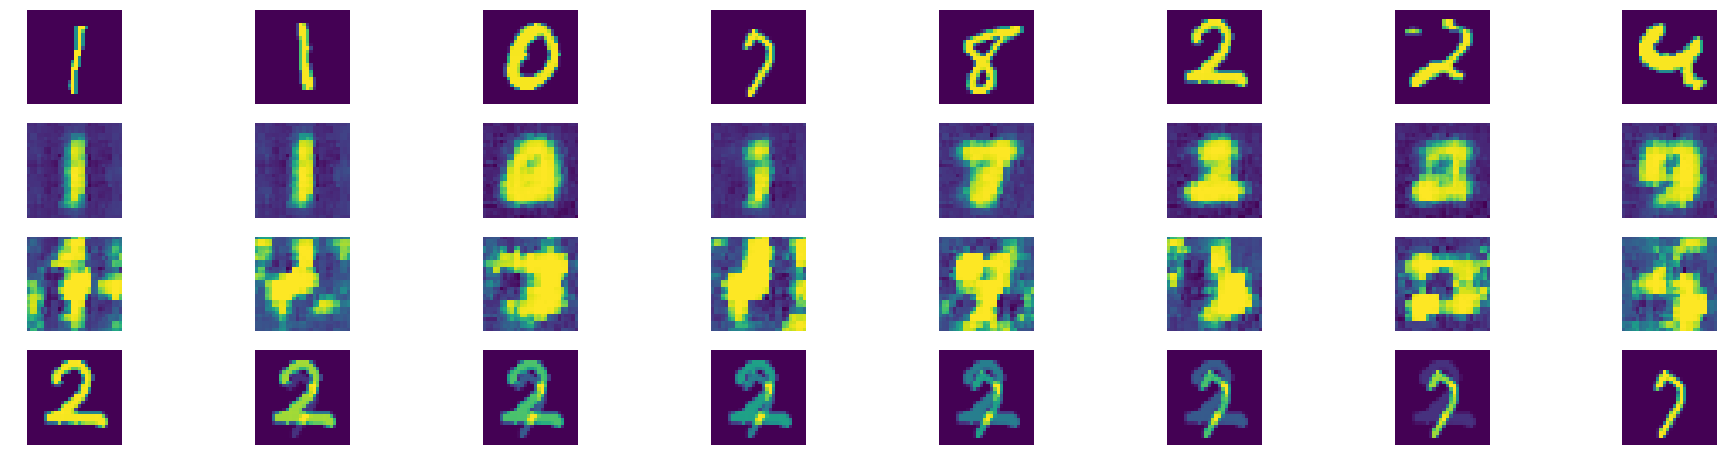

In [179]:
import math
import matplotlib.pyplot as plt
import numpy as np

def show_batch_of_images(img_batch, img_size=(1,1), grid_size=None):
    # How many squares for a square grid that can fit all images
    if grid_size == None:
        grid_size = math.ceil(math.sqrt(len(img_batch)))
        grid_size = (grid_size, grid_size)
    fig, axs = plt.subplots(grid_size[0], grid_size[1], figsize=(img_size[0] * grid_size[0], img_size[1] * grid_size[1]))
    # Turn the 2d array of axes to a 1d array
    axs = axs.flatten()
    for i, img in enumerate(img_batch):
        axs[i].imshow(img.reshape(28,28))
    # Do this separately in case the number of images we want to show is not a perfect square
    for i in range(grid_size[0] * grid_size[1]):
        axs[i].axis('off')
    plt.show()

show_batch_of_images(np.concatenate([originals, reconstructions, jittered, faded]), img_size=(test_batch_size, 1), grid_size=(4, test_batch_size))